In [28]:
import os
import re
import glob
import torch
import numpy as np
import pickle
from torch import nn
from torchao.quantization import (
    quantize_,
    int8_dynamic_activation_int8_weight,
    int8_weight_only,
    int4_weight_only,
)
import copy
from datetime import datetime

class DeepNN(nn.Module):
    def __init__(self, d: int, hidden_size: int, depth: int, mode: str = 'special', gamma: float = 1.0):
        super().__init__()
        self.gamma = gamma
        torch.set_default_dtype(torch.float32)
        
        layers = []
        prev_dim = d
        for _ in range(depth):
            linear = nn.Linear(prev_dim, hidden_size)
            
            if mode == 'special':
                gain = nn.init.calculate_gain('relu')
                std = gain / np.sqrt(prev_dim)
                nn.init.normal_(linear.weight, mean=0.0, std=std)
                nn.init.zeros_(linear.bias)
            else:
                nn.init.xavier_uniform_(linear.weight)
                nn.init.zeros_(linear.bias)
            
            layers.extend([
                linear,
                nn.ReLU()
            ])
            prev_dim = hidden_size
        
        final_layer = nn.Linear(prev_dim, 1)
        if mode == 'special':
            nn.init.normal_(final_layer.weight, std=0.01)
        else:
            nn.init.xavier_uniform_(final_layer.weight)
        nn.init.zeros_(final_layer.bias)
        layers.append(final_layer)
        
        self.network = nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.network(x).squeeze() / float(self.gamma)

def evaluate_model(model, X, y, out_idx=None):
    model.eval()
    with torch.no_grad():
        if out_idx is not None:
            y_pred = model(X)[:, out_idx]
        else:
            y_pred = model(X)
        mse = torch.mean((y_pred - y) ** 2).item()
    return mse

def pad_final_linear_layer(model, target_output_features=16):
    model_padded = copy.deepcopy(model)
    linear_layers = [module for module in model_padded.modules() if isinstance(module, nn.Linear)]
    if not linear_layers:
        raise ValueError("No nn.Linear layer found in the model.")
    
    final_layer = linear_layers[-1]
    current_out_features = final_layer.out_features
    in_features = final_layer.in_features
    
    if current_out_features >= target_output_features:
        raise ValueError(f"Current output features ({current_out_features}) >= target ({target_output_features}).")
    
    num_to_add = target_output_features - current_out_features
    with torch.no_grad():
        dummy_weights = torch.zeros((num_to_add, in_features), dtype=final_layer.weight.dtype, device=final_layer.weight.device)
        final_layer.weight = nn.Parameter(torch.cat([final_layer.weight, dummy_weights], dim=0))
        
        if final_layer.bias is not None:
            dummy_bias = torch.zeros(num_to_add, dtype=final_layer.bias.dtype, device=final_layer.bias.device)
            final_layer.bias = nn.Parameter(torch.cat([final_layer.bias, dummy_bias], dim=0))
    
    return model_padded

def quantize_fp16(model):
    model_fp16 = copy.deepcopy(model)
    model_fp16.half()
    return model_fp16

def quantize_int8_weight_only(model):
    model_int8_wo = copy.deepcopy(model)
    quantize_(model_int8_wo, int8_weight_only())
    return model_int8_wo

def quantize_int8_dynamic(model):
    model_int8 = copy.deepcopy(model)
    quantize_(model_int8, int8_dynamic_activation_int8_weight())
    return model_int8

def quantize_int4_weight_only(model):
    padded_model = pad_final_linear_layer(model, target_output_features=16)
    model_int4_wo = copy.deepcopy(padded_model).to(torch.bfloat16)
    quantize_(model_int4_wo, int4_weight_only(group_size=32, use_hqq=False))
    return model_int4_wo

def extract_n_train(filename):
    """Extract n_train value from filename."""
    match = re.search(r'n(\d+)_', filename)
    if match:
        return int(match.group(1))
    return None

def process_directory(input_dir, output_dir, d, hidden_size, depth, mode, gamma, lr):
    """Process all models in directory with given parameters."""
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    
    # Create output directory
    os.makedirs(output_dir, exist_ok=True)
    
    # Find all final model files in input directory
    model_files = glob.glob(os.path.join(input_dir, f'final_model_h{hidden_size}_d{depth}_n*_lr{lr}_*.pt'))
    
    results = {
        'fp32': {'train': {}, 'test': {}},
        'fp16': {'train': {}, 'test': {}},
        'int8_wo': {'train': {}, 'test': {}},
        'int8_dyn': {'train': {}, 'test': {}},
        'int4_wo': {'train': {}, 'test': {}},
    }
    
    # Load test data
    test_data_file = glob.glob(os.path.join(input_dir, 'test_dataset_*.pt'))[0]
    test_data = torch.load(test_data_file)
    X_test, y_test = test_data['X'].to(device), test_data['y'].to(device)
    
    for model_file in sorted(model_files):
        n_train = extract_n_train(model_file)
        if n_train is None:
            continue
            
        print(f"Processing model with n_train = {n_train}")
        
        # Load training data for this n_train
        train_data_file = glob.glob(os.path.join(input_dir, f'train_dataset_h{hidden_size}_d{depth}_n{n_train}_lr{lr}_*.pt'))[0]
        train_data = torch.load(train_data_file)
        X_train, y_train = train_data['X'].to(device), train_data['y'].to(device)
        
        # Load and evaluate original model
        model = DeepNN(d, hidden_size, depth, mode=mode, gamma=gamma).to(device)
        state_dict = torch.load(model_file)
        model.load_state_dict(state_dict)
        
        results['fp32']['train'][n_train] = evaluate_model(model, X_train, y_train)
        results['fp32']['test'][n_train] = evaluate_model(model, X_test, y_test)
        
        # FP16 quantization
        model_fp16 = quantize_fp16(model)
        results['fp16']['train'][n_train] = evaluate_model(model_fp16, X_train.half(), y_train.half())
        results['fp16']['test'][n_train] = evaluate_model(model_fp16, X_test.half(), y_test.half())
        
        # INT8 weight-only quantization
        model_int8_wo = quantize_int8_weight_only(model)
        results['int8_wo']['train'][n_train] = evaluate_model(model_int8_wo, X_train, y_train)
        results['int8_wo']['test'][n_train] = evaluate_model(model_int8_wo, X_test, y_test)
        
        # INT8 dynamic quantization
        model_int8 = quantize_int8_dynamic(model)
        results['int8_dyn']['train'][n_train] = evaluate_model(model_int8, X_train, y_train)
        results['int8_dyn']['test'][n_train] = evaluate_model(model_int8, X_test, y_test)
        
        # INT4 weight-only quantization
        model_int4_wo = quantize_int4_weight_only(model)
        results['int4_wo']['train'][n_train] = evaluate_model(
            model_int4_wo, 
            X_train.to(torch.bfloat16), 
            y_train.to(torch.bfloat16), 
            out_idx=0
        )
        results['int4_wo']['test'][n_train] = evaluate_model(
            model_int4_wo, 
            X_test.to(torch.bfloat16), 
            y_test.to(torch.bfloat16), 
            out_idx=0
        )
        
        # Save quantized models
        save_prefix = f'h{hidden_size}_d{depth}_n{n_train}_lr{lr}_g{gamma}_{mode}'
        torch.save(model_fp16.state_dict(), os.path.join(output_dir, f'model_fp16_{save_prefix}.pt'))
        torch.save(model_int8_wo.state_dict(), os.path.join(output_dir, f'model_int8wo_{save_prefix}.pt'))
        torch.save(model_int8.state_dict(), os.path.join(output_dir, f'model_int8dyn_{save_prefix}.pt'))
        torch.save(model_int4_wo.state_dict(), os.path.join(output_dir, f'model_int4wo_{save_prefix}.pt'))
        
    # Save results
    results_file = os.path.join(output_dir, f'quantization_results_h2000_{timestamp}.pkl')
    with open(results_file, 'wb') as f:
        pickle.dump(results, f)
    
    return results

def main():
    # Set your parameters directly here
    input_dir = "/mnt/users/goringn/NNs_vs_Kernels/stair_function/results/msp_anthro_true_mup_lr0005_gamma_1_modelsaved"  # Directory containing trained models
    output_dir = input_dir# "/mnt/users/goringn/NNs_vs_Kernels/stair_function/results/msp_anthro_true_mup_lr0005_gamma_1_modelsaved"  # Directory to save quantized models
    d = 30  # Input dimension
    hidden_size = 2000  # Hidden layer size
    depth = 4  # Network depth
    mode = 'mup_pennington'  # Initialization mode
    gamma = 1.0  # Gamma parameter
    lr = 0.005  # Learning rate used in training
    
    print(f"Processing models with parameters:")
    print(f"Hidden size: {hidden_size}")
    print(f"Depth: {depth}")
    print(f"Learning rate: {lr}")
    print(f"Gamma: {gamma}")
    print(f"Mode: {mode}")
    
    results = process_directory(
        input_dir,
        output_dir,
        d,
        hidden_size,
        depth,
        mode,
        gamma,
        lr
    )
    
    print("Quantization complete. Results saved in output directory.")

if __name__ == "__main__":
    main()

Processing models with parameters:
Hidden size: 2000
Depth: 4
Learning rate: 0.005
Gamma: 1.0
Mode: mup_pennington
Processing model with n_train = 10000


/tmp/ipykernel_3814160/2813255531.py:139: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_data = torch.load(test_data_file)
/tmp/ipykernel_3814160/2813255531.py:151: Futu

KeyboardInterrupt: 

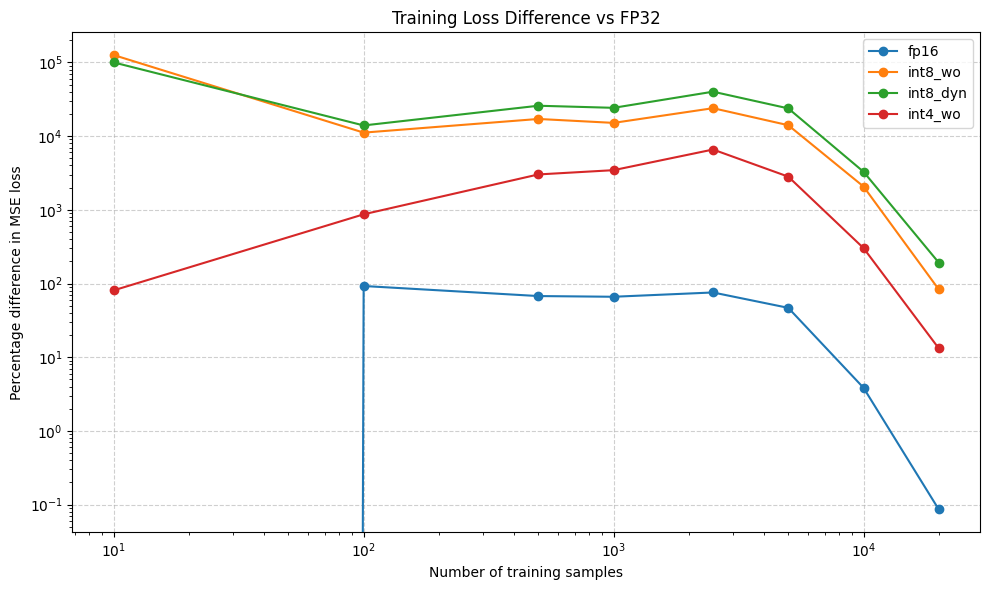

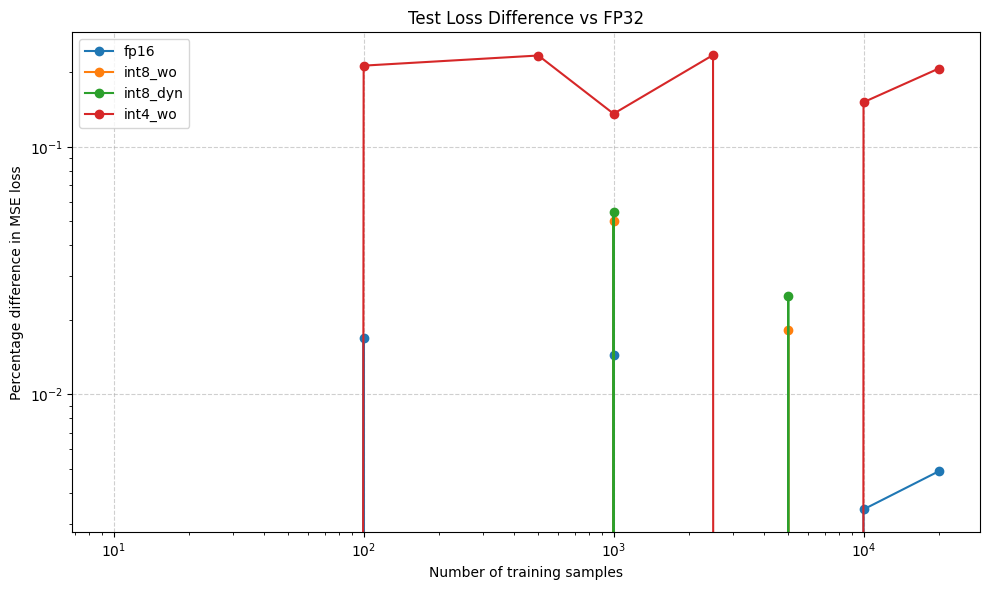

In [9]:
import matplotlib.pyplot as plt
import pickle
import os

def plot_dict_of_lists(data_dict, x_values=None, xlabel='X-axis', ylabel='Y-axis',
                      title='Plot', log_x=False, log_y=False, save_path=None):
    """
    Plots a dictionary of lists with a custom x-axis and optional logarithmic scaling.
    """
    plt.figure(figsize=(10, 6))

    if x_values is None:
        x_values = range(len(next(iter(data_dict.values()))))

    for label, values in data_dict.items():
        plt.plot(x_values, values, label=label, marker='o')

    if log_x:
        plt.xscale('log')
    if log_y:
        plt.yscale('log')

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend(loc='best')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path)
    plt.show()

def calculate_percentage_differences(results, n_train_sizes):
    """
    Calculate percentage differences for each quantization method relative to fp32.
    """
    percent_diff_train = {}
    percent_diff_test = {}
    
    quantization_methods = ['fp16', 'int8_wo', 'int8_dyn', 'int4_wo']
    
    for method in quantization_methods:
        percent_diff_train[method] = [
            (results[method]['train'][n] - results['fp32']['train'][n]) / results['fp32']['train'][n] * 100 
            for n in n_train_sizes
        ]
        percent_diff_test[method] = [
            (results[method]['test'][n] - results['fp32']['test'][n]) / results['fp32']['test'][n] * 100 
            for n in n_train_sizes
        ]
    
    return percent_diff_train, percent_diff_test

def main():
    # Directory containing the results
    results_dir = "/mnt/users/goringn/NNs_vs_Kernels/stair_function/results/msp_anthro_true_mup_lr0005_gamma_1_modelsaved/"
    
    # Find the most recent results file
    results_files = [f for f in os.listdir(results_dir) if f.startswith('quantization_results_')]
    latest_results_file = max(results_files)
    
    # Load results
    with open(os.path.join(results_dir, latest_results_file), 'rb') as f:
        results = pickle.load(f)
    
    # Define training sizes (modify as needed)
    n_train_sizes = [10, 100, 500, 1000, 2500, 5000, 10000, 20000]
    
    # Calculate percentage differences
    percent_diff_train, percent_diff_test = calculate_percentage_differences(results, n_train_sizes)
    
    # Create output directory for plots
    plots_dir = os.path.join(results_dir, 'plots')
    os.makedirs(plots_dir, exist_ok=True)
    
    # Plot training loss differences
    plot_dict_of_lists(
        percent_diff_train, 
        x_values=n_train_sizes,
        xlabel='Number of training samples',
        ylabel='Percentage difference in MSE loss',
        title='Training Loss Difference vs FP32',
        log_x=True,
        log_y=True,
        save_path=os.path.join(plots_dir, 'training_loss_diff.png')
    )
    
    # Plot test loss differences
    plot_dict_of_lists(
        percent_diff_test,
        x_values=n_train_sizes,
        xlabel='Number of training samples',
        ylabel='Percentage difference in MSE loss',
        title='Test Loss Difference vs FP32',
        log_x=True,
        log_y=True,
        save_path=os.path.join(plots_dir, 'test_loss_diff.png')
    )

if __name__ == "__main__":
    main()

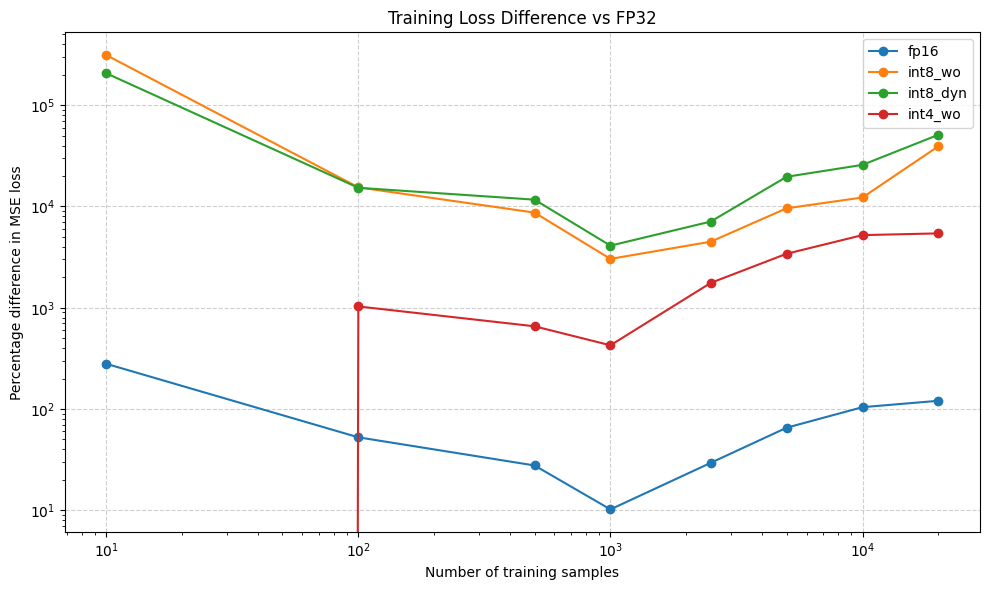

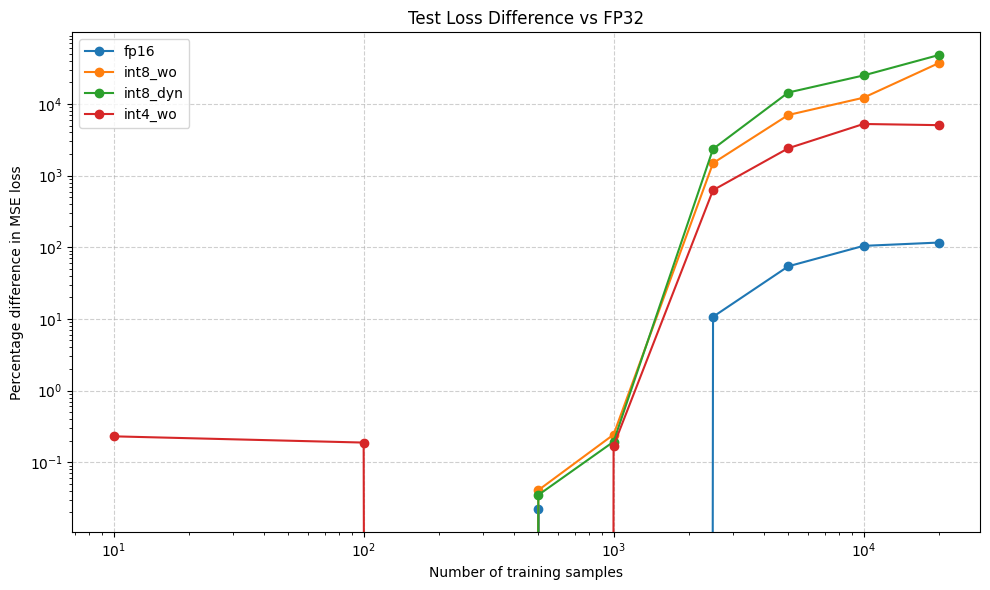

In [7]:
import matplotlib.pyplot as plt
import pickle
import os

def plot_dict_of_lists(data_dict, x_values=None, xlabel='X-axis', ylabel='Y-axis',
                      title='Plot', log_x=False, log_y=False, save_path=None):
    """
    Plots a dictionary of lists with a custom x-axis and optional logarithmic scaling.
    """
    plt.figure(figsize=(10, 6))

    if x_values is None:
        x_values = range(len(next(iter(data_dict.values()))))

    for label, values in data_dict.items():
        plt.plot(x_values, values, label=label, marker='o')

    if log_x:
        plt.xscale('log')
    if log_y:
        plt.yscale('log')

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend(loc='best')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path)
    plt.show()

def calculate_percentage_differences(results, n_train_sizes):
    """
    Calculate percentage differences for each quantization method relative to fp32.
    """
    percent_diff_train = {}
    percent_diff_test = {}
    
    quantization_methods = ['fp16', 'int8_wo', 'int8_dyn', 'int4_wo']
    
    for method in quantization_methods:
        percent_diff_train[method] = [
            (results[method]['train'][n] - results['fp32']['train'][n]) / results['fp32']['train'][n] * 100 
            for n in n_train_sizes
        ]
        percent_diff_test[method] = [
            (results[method]['test'][n] - results['fp32']['test'][n]) / results['fp32']['test'][n] * 100 
            for n in n_train_sizes
        ]
    
    return percent_diff_train, percent_diff_test

def main():
    # Directory containing the results
    results_dir = "/mnt/users/goringn/NNs_vs_Kernels/stair_function/results/msp_anthro_false_mup_lr0005_gamma_1_modelsaved/"
    
    # Find the most recent results file
    results_files = [f for f in os.listdir(results_dir) if f.startswith('quantization_results_')]
    latest_results_file = max(results_files)
    
    # Load results
    with open(os.path.join(results_dir, latest_results_file), 'rb') as f:
        results = pickle.load(f)
    
    # Define training sizes (modify as needed)
    n_train_sizes = [10, 100, 500, 1000, 2500, 5000, 10000, 20000]
    
    # Calculate percentage differences
    percent_diff_train, percent_diff_test = calculate_percentage_differences(results, n_train_sizes)
    
    # Create output directory for plots
    plots_dir = os.path.join(results_dir, 'plots')
    os.makedirs(plots_dir, exist_ok=True)
    
    # Plot training loss differences
    plot_dict_of_lists(
        percent_diff_train, 
        x_values=n_train_sizes,
        xlabel='Number of training samples',
        ylabel='Percentage difference in MSE loss',
        title='Training Loss Difference vs FP32',
        log_x=True,
        log_y=True,
        save_path=os.path.join(plots_dir, 'training_loss_diff.png')
    )
    
    # Plot test loss differences
    plot_dict_of_lists(
        percent_diff_test,
        x_values=n_train_sizes,
        xlabel='Number of training samples',
        ylabel='Percentage difference in MSE loss',
        title='Test Loss Difference vs FP32',
        log_x=True,
        log_y=True,
        save_path=os.path.join(plots_dir, 'test_loss_diff.png')
    )

if __name__ == "__main__":
    main()

Loading results from /mnt/users/goringn/NNs_vs_Kernels/stair_function/results/msp_anthro_false_mup_lr0005_gamma_1_modelsaved/pruning_results_20250127_195617.pkl
Found 8 training sizes: [10, 100, 500, 1000, 2500, 5000, 10000, 20000]
Found 7 pruning ratios: ['0.5', '0.7', '0.8', '0.9', '0.95', '0.98', '0.99']


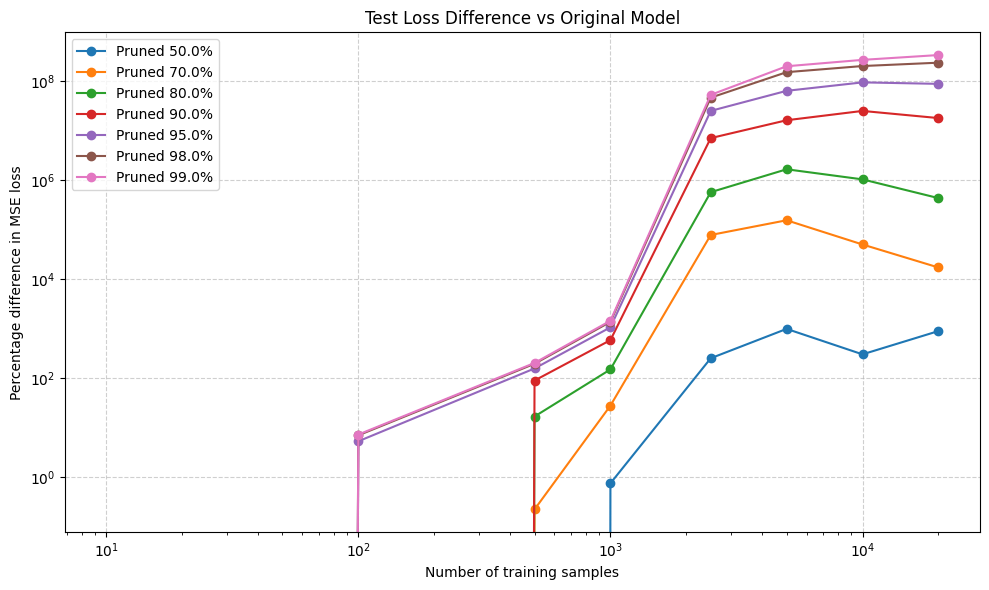

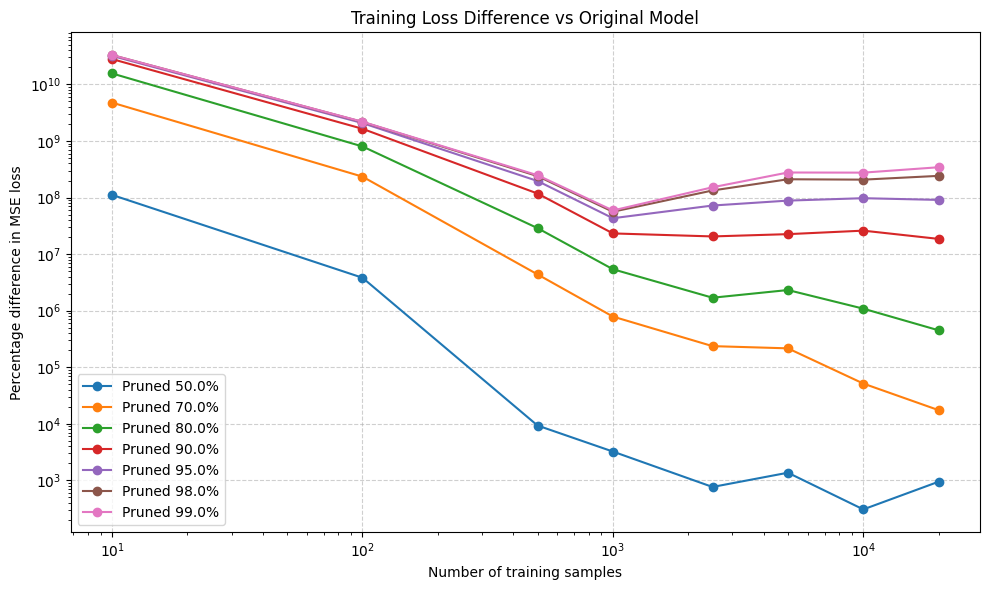

In [ ]:
##### polynomial qunatization

In [25]:
import os
import re
import glob
import torch
import numpy as np
import pickle
from torch import nn
from torchao.quantization import (
    quantize_,
    int8_dynamic_activation_int8_weight,
    int8_weight_only,
    int4_weight_only,
)
import copy
from datetime import datetime

class DeepNN(nn.Module):
    def __init__(self, d: int, hidden_size: int, depth: int, mode: str = 'mup_pennington'):
        super().__init__()
        
        torch.set_default_dtype(torch.float32)
        
        layers = []
        prev_dim = d
        
        for _ in range(depth):
            linear = nn.Linear(prev_dim, hidden_size)
            
            if mode == 'mup_pennington':
                std = 1.0 / np.sqrt(prev_dim)
                nn.init.normal_(linear.weight, mean=0.0, std=std)
                nn.init.zeros_(linear.bias)
            else:
                nn.init.xavier_uniform_(linear.weight)
                nn.init.zeros_(linear.bias)
            
            layers.extend([
                linear,
                nn.ReLU()
            ])
            prev_dim = hidden_size
        
        final_layer = nn.Linear(prev_dim, 1)
        if mode == 'mup_pennington':
            std = 1.0 / np.sqrt(prev_dim)
            nn.init.normal_(final_layer.weight, std=std)
        else:
            nn.init.xavier_uniform_(final_layer.weight)
        nn.init.zeros_(final_layer.bias)
        layers.append(final_layer)
        
        self.network = nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.network(x)

def evaluate_model(model, X, y, out_idx=None):
    model.eval()
    with torch.no_grad():
        if out_idx is not None:
            y_pred = model(X)[:, out_idx]
        else:
            y_pred = model(X).reshape(-1)
        mse = torch.mean((y_pred - y.reshape(-1)) ** 2).item()
    return mse

def pad_final_linear_layer(model, target_output_features=16):
    model_padded = copy.deepcopy(model)
    linear_layers = [module for module in model_padded.modules() if isinstance(module, nn.Linear)]
    if not linear_layers:
        raise ValueError("No nn.Linear layer found in the model.")
    
    final_layer = linear_layers[-1]
    current_out_features = final_layer.out_features
    in_features = final_layer.in_features
    
    if current_out_features >= target_output_features:
        raise ValueError(f"Current output features ({current_out_features}) >= target ({target_output_features}).")
    
    num_to_add = target_output_features - current_out_features
    with torch.no_grad():
        dummy_weights = torch.zeros((num_to_add, in_features), dtype=final_layer.weight.dtype, device=final_layer.weight.device)
        final_layer.weight = nn.Parameter(torch.cat([final_layer.weight, dummy_weights], dim=0))
        
        if final_layer.bias is not None:
            dummy_bias = torch.zeros(num_to_add, dtype=final_layer.bias.dtype, device=final_layer.bias.device)
            final_layer.bias = nn.Parameter(torch.cat([final_layer.bias, dummy_bias], dim=0))
    
    return model_padded

def quantize_fp16(model):
    model_fp16 = copy.deepcopy(model)
    model_fp16.half()
    return model_fp16

def quantize_int8_weight_only(model):
    model_int8_wo = copy.deepcopy(model)
    quantize_(model_int8_wo, int8_weight_only())
    return model_int8_wo

def quantize_int8_dynamic(model):
    model_int8 = copy.deepcopy(model)
    quantize_(model_int8, int8_dynamic_activation_int8_weight())
    return model_int8

def quantize_int4_weight_only(model):
    padded_model = pad_final_linear_layer(model, target_output_features=16)
    model_int4_wo = copy.deepcopy(padded_model).to(torch.bfloat16)
    quantize_(model_int4_wo, int4_weight_only(group_size=32, use_hqq=False))
    return model_int4_wo

def extract_model_params(filename):
    """Extract model parameters from filename."""
    match = re.search(r'h(\d+)_d(\d+)_n(\d+)_lr([\d\.]+)_', filename)
    if match:
        return {
            'hidden_size': int(match.group(1)),
            'depth': int(match.group(2)),
            'n_train': int(match.group(3)),
            'lr': float(match.group(4))
        }
    return None

def process_directory(input_dir, output_dir, mode='mup_pennington', ambient_dim=20, model_pattern=None):
    """Process models in directory matching specific hyperparameters."""
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    
    # Create output directory
    os.makedirs(output_dir, exist_ok=True)
    
    # Find model files matching the specified pattern
    if model_pattern:
        model_files = glob.glob(os.path.join(input_dir, model_pattern))
    else:
        model_files = glob.glob(os.path.join(input_dir, 'final_model_*.pt'))
    
    results = {
        'fp32': {'train': {}, 'test': {}},
        'fp16': {'train': {}, 'test': {}},
        'int8_wo': {'train': {}, 'test': {}},
        'int8_dyn': {'train': {}, 'test': {}},
        'int4_wo': {'train': {}, 'test': {}},
    }
    
    for model_file in sorted(model_files):
        params = extract_model_params(model_file)
        if params is None:
            continue
            
        print(f"Processing model with parameters: {params}")
        
        # Find corresponding dataset files
        model_prefix = f'h{params["hidden_size"]}_d{params["depth"]}_n{params["n_train"]}_lr{params["lr"]}'
        dataset_pattern = f'dataset_{model_prefix}_*'
        dataset_files = glob.glob(os.path.join(input_dir, dataset_pattern))
        
        if not dataset_files:
            print(f"No dataset found for model {model_file}")
            continue
            
        # Load training data
        train_data = torch.load(dataset_files[0])
        X_train, y_train = train_data['X'].to(device), train_data['y'].to(device)
        
        # Load and evaluate original model
        model = DeepNN(ambient_dim, params['hidden_size'], params['depth'], mode=mode).to(device)
        state_dict = torch.load(model_file)
        model.load_state_dict(state_dict)
        
        results['fp32']['train'][params['n_train']] = evaluate_model(model, X_train, y_train)
        
        # FP16 quantization
        model_fp16 = quantize_fp16(model)
        results['fp16']['train'][params['n_train']] = evaluate_model(
            model_fp16, 
            X_train.half(), 
            y_train.half()
        )
        
        # INT8 weight-only quantization
        model_int8_wo = quantize_int8_weight_only(model)
        results['int8_wo']['train'][params['n_train']] = evaluate_model(
            model_int8_wo, 
            X_train, 
            y_train
        )
        
        # INT8 dynamic quantization
        model_int8 = quantize_int8_dynamic(model)
        results['int8_dyn']['train'][params['n_train']] = evaluate_model(
            model_int8, 
            X_train, 
            y_train
        )
        
        # INT4 weight-only quantization
        model_int4_wo = quantize_int4_weight_only(model)
        results['int4_wo']['train'][params['n_train']] = evaluate_model(
            model_int4_wo, 
            X_train.to(torch.bfloat16), 
            y_train.to(torch.bfloat16), 
            out_idx=0
        )
        
        # Save quantized models
        save_prefix = f'{model_prefix}_{mode}'
        torch.save(model_fp16.state_dict(), os.path.join(output_dir, f'model_fp16_{save_prefix}.pt'))
        torch.save(model_int8_wo.state_dict(), os.path.join(output_dir, f'model_int8wo_{save_prefix}.pt'))
        torch.save(model_int8.state_dict(), os.path.join(output_dir, f'model_int8dyn_{save_prefix}.pt'))
        torch.save(model_int4_wo.state_dict(), os.path.join(output_dir, f'model_int4wo_{save_prefix}.pt'))
        
    # Save results
    results_file = os.path.join(output_dir, f'quantization_results_{timestamp}.pkl')
    with open(results_file, 'wb') as f:
        pickle.dump(results, f)
    
    return results

def main():
    # Set your parameters directly here
    input_dir = "/mnt/users/goringn/NNs_vs_Kernels/low_dim_poly/results/low_dim_poly_prune_2801_true"  # Directory containing trained models
    output_dir = input_dir  # Save in same directory
    mode = 'mup_pennington'  # Initialization mode
    ambient_dim = 20  # Input dimension
    
    # Hyperparameters matching your training setup
    hidden_sizes = [1000]
    depths = [4]
    learning_rates = [0.001]
    
    print(f"Processing models with parameters:")
    print(f"Mode: {mode}")
    print(f"Ambient dimension: {ambient_dim}")
    print(f"Hidden sizes: {hidden_sizes}")
    print(f"Depths: {depths}")
    print(f"Learning rates: {learning_rates}")
    
    # Process each combination of hyperparameters
    for hidden_size in hidden_sizes:
        for depth in depths:
            for lr in learning_rates:
                print(f"\nProcessing models with h={hidden_size}, d={depth}, lr={lr}")
                
                # Find specific models matching these hyperparameters
                model_pattern = f'final_model_h{hidden_size}_d{depth}_*_lr{lr}_*.pt'
                specific_model_files = glob.glob(os.path.join(input_dir, model_pattern))
                
                if not specific_model_files:
                    print(f"No models found for h={hidden_size}, d={depth}, lr={lr}")
                    continue
                
                results = process_directory(
                    input_dir,
                    output_dir,
                    mode=mode,
                    ambient_dim=ambient_dim,
                    model_pattern=model_pattern
                )
    
    print("Quantization complete. Results saved in output directory.")

if __name__ == "__main__":
    main()

Processing models with parameters:
Mode: mup_pennington
Ambient dimension: 20
Hidden sizes: [1000]
Depths: [4]
Learning rates: [0.001]

Processing models with h=1000, d=4, lr=0.001
Processing model with parameters: {'hidden_size': 1000, 'depth': 4, 'n_train': 10000, 'lr': 0.001}


/tmp/ipykernel_3814160/594199158.py:163: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_data = torch.load(dataset_files[0])
/tmp/ipykernel_3814160/594199158.py:168: Fut

Processing model with parameters: {'hidden_size': 1000, 'depth': 4, 'n_train': 1000, 'lr': 0.001}
Processing model with parameters: {'hidden_size': 1000, 'depth': 4, 'n_train': 100, 'lr': 0.001}
Processing model with parameters: {'hidden_size': 1000, 'depth': 4, 'n_train': 10, 'lr': 0.001}
Processing model with parameters: {'hidden_size': 1000, 'depth': 4, 'n_train': 20000, 'lr': 0.001}
Processing model with parameters: {'hidden_size': 1000, 'depth': 4, 'n_train': 2500, 'lr': 0.001}
Processing model with parameters: {'hidden_size': 1000, 'depth': 4, 'n_train': 40000, 'lr': 0.001}
Processing model with parameters: {'hidden_size': 1000, 'depth': 4, 'n_train': 5000, 'lr': 0.001}
Processing model with parameters: {'hidden_size': 1000, 'depth': 4, 'n_train': 500, 'lr': 0.001}
Quantization complete. Results saved in output directory.


Loading results from /mnt/users/goringn/NNs_vs_Kernels/low_dim_poly/results/low_dim_poly_prune_2801_false/quantization_results_20250128_151040.pkl
Found training sizes: [10, 100, 500, 1000, 2500, 5000, 10000, 20000, 40000]


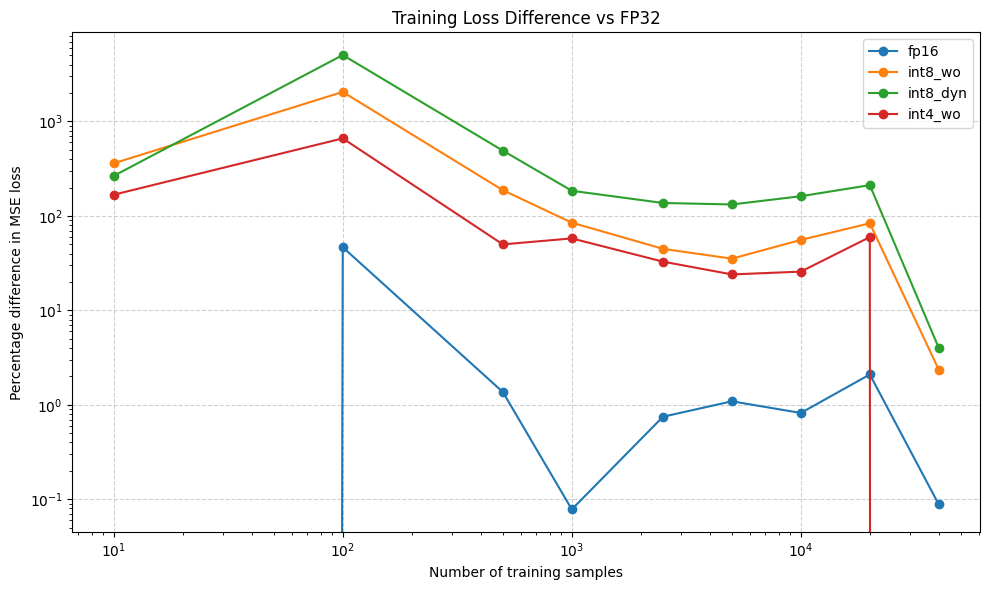

In [23]:
import matplotlib.pyplot as plt
import pickle
import os

def plot_dict_of_lists(data_dict, x_values=None, xlabel='X-axis', ylabel='Y-axis',
                      title='Plot', log_x=False, log_y=False, save_path=None):
    """
    Plots a dictionary of lists with a custom x-axis and optional logarithmic scaling.
    """
    plt.figure(figsize=(10, 6))
    
    if x_values is None:
        x_values = range(len(next(iter(data_dict.values()))))
    
    for label, values in data_dict.items():
        plt.plot(x_values, values, label=label, marker='o')
    
    if log_x:
        plt.xscale('log')
    if log_y:
        plt.yscale('log')
    
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend(loc='best')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path)
    plt.show()

def calculate_percentage_differences(results, n_train_sizes):
    """
    Calculate percentage differences for each quantization method relative to fp32.
    Only includes sizes that exist in the data.
    """
    percent_diff = {}
    quantization_methods = ['fp16', 'int8_wo', 'int8_dyn', 'int4_wo']
    
    for method in quantization_methods:
        percent_diff[method] = []
        for n in n_train_sizes:
            if n in results[method]['train'] and n in results['fp32']['train']:
                diff = ((results[method]['train'][n] - results['fp32']['train'][n]) 
                       / results['fp32']['train'][n] * 100)
                percent_diff[method].append(diff)
    
    return percent_diff

def main():
    # Replace with your specific pickle file path
    pickle_file = "/mnt/users/goringn/NNs_vs_Kernels/low_dim_poly/results/low_dim_poly_prune_2801_false/quantization_results_20250128_151040.pkl"
    
    # Load results
    print(f"Loading results from {pickle_file}")
    with open(pickle_file, 'rb') as f:
        results = pickle.load(f)
    
    # Get all available n_train values (sorted)
    n_train_sizes = sorted(results['fp32']['train'].keys())
    print(f"Found training sizes: {n_train_sizes}")
    
    # Calculate percentage differences
    percent_diff = calculate_percentage_differences(results, n_train_sizes)
    
    # Create plots directory (in same location as pickle file)
    plots_dir = os.path.join(os.path.dirname(pickle_file), 'plots')
    os.makedirs(plots_dir, exist_ok=True)
    
    # Plot training loss differences
    plot_dict_of_lists(
        percent_diff,
        x_values=n_train_sizes,
        xlabel='Number of training samples',
        ylabel='Percentage difference in MSE loss',
        title='Training Loss Difference vs FP32',
        log_x=True,
        log_y=True,
        save_path=os.path.join(plots_dir, 'training_loss_diff.png')
    )

if __name__ == "__main__":
    main()

Loading results from /mnt/users/goringn/NNs_vs_Kernels/low_dim_poly/results/low_dim_poly_prune_2801_false/quantization_results_20250128_151349.pkl
Found training sizes: [10, 100, 500, 1000, 2500, 5000, 10000, 20000, 40000]


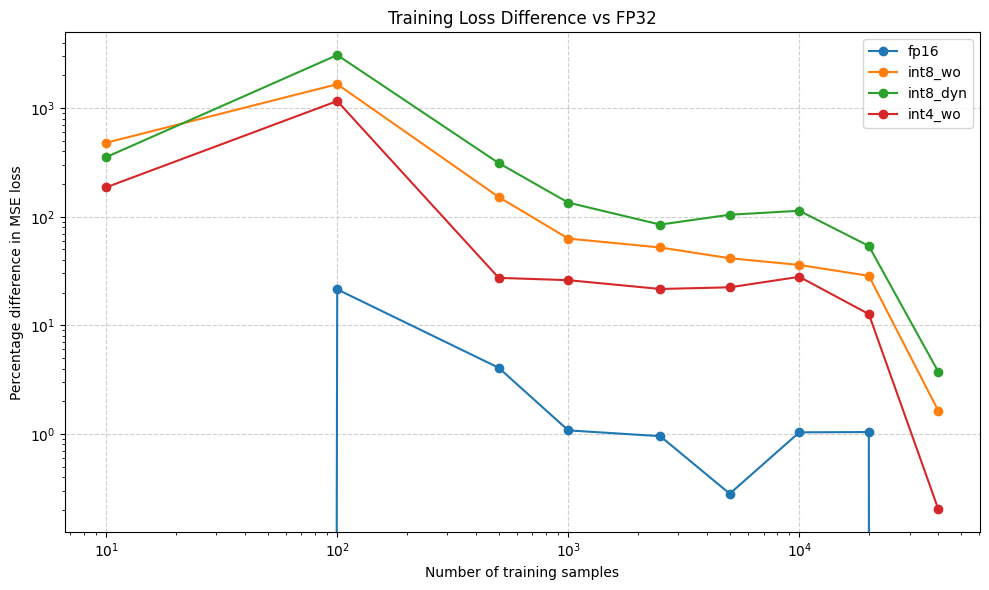

In [24]:
import matplotlib.pyplot as plt
import pickle
import os

def plot_dict_of_lists(data_dict, x_values=None, xlabel='X-axis', ylabel='Y-axis',
                      title='Plot', log_x=False, log_y=False, save_path=None):
    """
    Plots a dictionary of lists with a custom x-axis and optional logarithmic scaling.
    """
    plt.figure(figsize=(10, 6))
    
    if x_values is None:
        x_values = range(len(next(iter(data_dict.values()))))
    
    for label, values in data_dict.items():
        plt.plot(x_values, values, label=label, marker='o')
    
    if log_x:
        plt.xscale('log')
    if log_y:
        plt.yscale('log')
    
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend(loc='best')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path)
    plt.show()

def calculate_percentage_differences(results, n_train_sizes):
    """
    Calculate percentage differences for each quantization method relative to fp32.
    Only includes sizes that exist in the data.
    """
    percent_diff = {}
    quantization_methods = ['fp16', 'int8_wo', 'int8_dyn', 'int4_wo']
    
    for method in quantization_methods:
        percent_diff[method] = []
        for n in n_train_sizes:
            if n in results[method]['train'] and n in results['fp32']['train']:
                diff = ((results[method]['train'][n] - results['fp32']['train'][n]) 
                       / results['fp32']['train'][n] * 100)
                percent_diff[method].append(diff)
    
    return percent_diff

def main():
    # Replace with your specific pickle file path
    pickle_file = "/mnt/users/goringn/NNs_vs_Kernels/low_dim_poly/results/low_dim_poly_prune_2801_false/quantization_results_20250128_151349.pkl"
    
    # Load results
    print(f"Loading results from {pickle_file}")
    with open(pickle_file, 'rb') as f:
        results = pickle.load(f)
    
    # Get all available n_train values (sorted)
    n_train_sizes = sorted(results['fp32']['train'].keys())
    print(f"Found training sizes: {n_train_sizes}")
    
    # Calculate percentage differences
    percent_diff = calculate_percentage_differences(results, n_train_sizes)
    
    # Create plots directory (in same location as pickle file)
    plots_dir = os.path.join(os.path.dirname(pickle_file), 'plots')
    os.makedirs(plots_dir, exist_ok=True)
    
    # Plot training loss differences
    plot_dict_of_lists(
        percent_diff,
        x_values=n_train_sizes,
        xlabel='Number of training samples',
        ylabel='Percentage difference in MSE loss',
        title='Training Loss Difference vs FP32',
        log_x=True,
        log_y=True,
        save_path=os.path.join(plots_dir, 'training_loss_diff.png')
    )

if __name__ == "__main__":
    main()

Loading results from /mnt/users/goringn/NNs_vs_Kernels/low_dim_poly/results/low_dim_poly_prune_2801_true/quantization_results_20250128_152137.pkl
Found training sizes: [10, 100, 500, 1000, 2500, 5000, 10000, 20000, 40000]


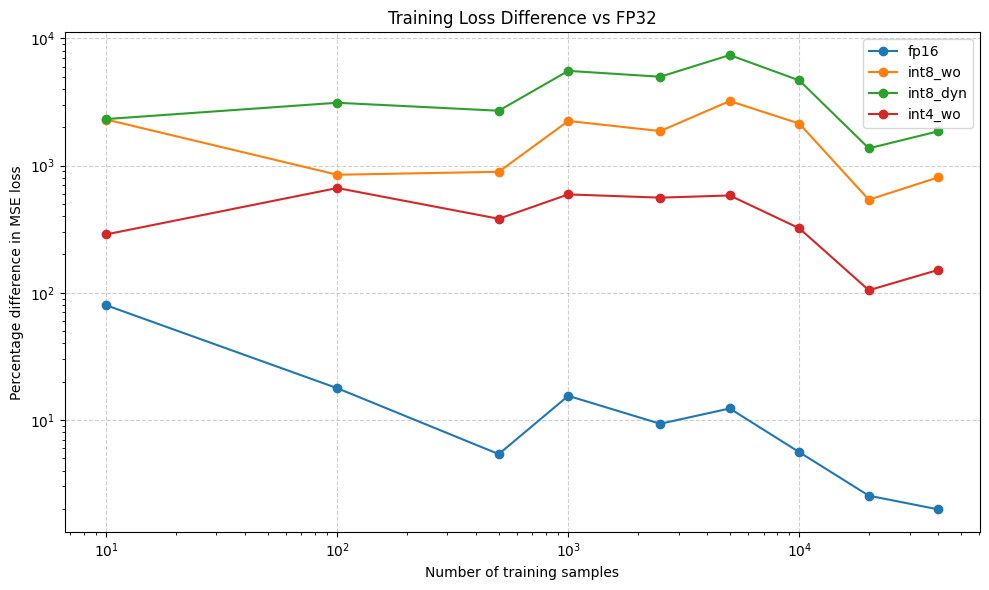

In [27]:
import matplotlib.pyplot as plt
import pickle
import os

def plot_dict_of_lists(data_dict, x_values=None, xlabel='X-axis', ylabel='Y-axis',
                      title='Plot', log_x=False, log_y=False, save_path=None):
    """
    Plots a dictionary of lists with a custom x-axis and optional logarithmic scaling.
    """
    plt.figure(figsize=(10, 6))
    
    if x_values is None:
        x_values = range(len(next(iter(data_dict.values()))))
    
    for label, values in data_dict.items():
        plt.plot(x_values, values, label=label, marker='o')
    
    if log_x:
        plt.xscale('log')
    if log_y:
        plt.yscale('log')
    
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend(loc='best')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path)
    plt.show()

def calculate_percentage_differences(results, n_train_sizes):
    """
    Calculate percentage differences for each quantization method relative to fp32.
    Only includes sizes that exist in the data.
    """
    percent_diff = {}
    quantization_methods = ['fp16', 'int8_wo', 'int8_dyn', 'int4_wo']
    
    for method in quantization_methods:
        percent_diff[method] = []
        for n in n_train_sizes:
            if n in results[method]['train'] and n in results['fp32']['train']:
                diff = ((results[method]['train'][n] - results['fp32']['train'][n]) 
                       / results['fp32']['train'][n] * 100)
                percent_diff[method].append(diff)
    
    return percent_diff

def main():
    # Replace with your specific pickle file path
    pickle_file = "/mnt/users/goringn/NNs_vs_Kernels/low_dim_poly/results/low_dim_poly_prune_2801_true/quantization_results_20250128_152137.pkl"
    
    # Load results
    print(f"Loading results from {pickle_file}")
    with open(pickle_file, 'rb') as f:
        results = pickle.load(f)
    
    # Get all available n_train values (sorted)
    n_train_sizes = sorted(results['fp32']['train'].keys())
    print(f"Found training sizes: {n_train_sizes}")
    
    # Calculate percentage differences
    percent_diff = calculate_percentage_differences(results, n_train_sizes)
    
    # Create plots directory (in same location as pickle file)
    plots_dir = os.path.join(os.path.dirname(pickle_file), 'plots')
    os.makedirs(plots_dir, exist_ok=True)
    
    # Plot training loss differences
    plot_dict_of_lists(
        percent_diff,
        x_values=n_train_sizes,
        xlabel='Number of training samples',
        ylabel='Percentage difference in MSE loss',
        title='Training Loss Difference vs FP32',
        log_x=True,
        log_y=True,
        save_path=os.path.join(plots_dir, 'training_loss_diff.png')
    )

if __name__ == "__main__":
    main()